Para más información consultar Readme.txt

# Librerias

In [1]:
from keras.preprocessing import image   # for preprocessing the images
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd

from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

## Función para graficar validacion accuracy

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

## Extract caracteristicas p/modelo

In [2]:
data = pd.read_csv('data_completo.csv')# reading the csv file
data.head()      # printing first five rows of the file

,image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,0
2,frame2.jpg,0
3,frame3.jpg,0
4,frame4.jpg,0


In [7]:
X = [ ]     # creating an empty array
for img_name in data.image_ID:
    img = plt.imread('./Labeled/' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

<ipython-input-7-24617b28b408>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)    # converting list to array


In [9]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

Haciendo reshapes

In [10]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

Preprocesado para el modelo

In [12]:
#X = preprocess_input(X, mode='tf')      # preprocessing the input data
X = preprocess_input(X, data_format=None) 

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

## Construyendo el modelo

In [14]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

58900480/58889256 [==============================] - 10s 0us/step


In [16]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((88, 7, 7, 512), (39, 7, 7, 512))

In [18]:
X_train = X_train.reshape(88, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(39, 7*7*512)

In [19]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [22]:
# i. Building the model
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 25,693,186
Trainable params: 25,693,186
Non-trainable params: 0
_________________________________________________________________


In [24]:
# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/100
3/3 [==============================] - 1s 270ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3934 - val_accuracy: 0.9231
Epoch 2/100
3/3 [==============================] - 1s 239ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3940 - val_accuracy: 0.9231
Epoch 3/100
3/3 [==============================] - 1s 220ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3947 - val_accuracy: 0.9231
Epoch 4/100
3/3 [==============================] - 1s 252ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3955 - val_accuracy: 0.9231
Epoch 5/100
3/3 [==============================] - 1s 213ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3962 - val_accuracy: 0.9231
Epoch 6/100
3/3 [==============================] - 1s 222ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3970 - val_accuracy: 0.9231
Epoch 7/100
3/3 [==============================] - 1s 231ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 0.9231
Epoch 8/100
3

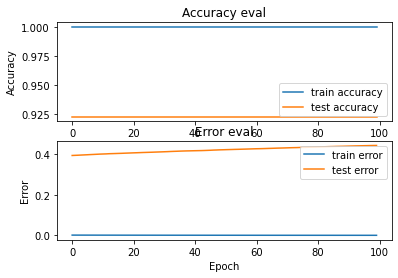

In [27]:
# iii. Training the model
history=model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))
plot_history(history)

## Prueba con videos en ambos estados

#### Extrayendo las frames del video prueba

In [100]:
count = 0
videoFile = "./Raw/Ambos_test/VID_20220202_155903.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


### Vid. 1

In [101]:
cols_name = ['image_ID']
list0=[["test0.jpg"],
      ["test1.jpg"],
      ["test2.jpg"],
      ["test3.jpg"],
      ["test4.jpg"],
      ["test5.jpg"],
      ["test6.jpg"],
      ["test7.jpg"],
      ["test8.jpg"],
      ["test9.jpg"],
      ["test10.jpg"],
      ["test11.jpg"],
      ["test12.jpg"]
      ]

In [102]:
df=pd.DataFrame(list0,columns=cols_name)
df

,image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg
5,test5.jpg
6,test6.jpg
7,test7.jpg
8,test8.jpg
9,test9.jpg


In [103]:
df.to_csv('test.csv',index=False)


In [104]:
test=pd.read_csv("test.csv")
test.head()

,image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [105]:
test_image = []
for img_name in test.image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [106]:
test_img.shape

(13, 1080, 1920, 3)

Reshape

In [107]:
test_image0 = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image0.append(a)
test_image = np.array(test_image0)

In [108]:
test_image.shape

(13, 224, 224, 3)

In [109]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)


In [110]:
# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)


In [111]:
test_image.shape

(13, 7, 7, 512)

In [112]:
# converting the images to 1-D form
test_image = test_image.reshape(13, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

Predicciones

In [120]:
predictions = model.predict(test_image)

In [123]:
predictions=np.argmax(predictions,axis=1)

In [124]:
print("El tiempo/frames en pantalla dormido es de", predictions[predictions==0].shape[0], "seconds")
print("El tiempo/frames en pantalla despierto es de", predictions[predictions==1].shape[0], "seconds")

The screen time of Sleep is 7 seconds
The screen time of Wake is 6 seconds


Participante Mi.
De los 11 segundos se extrajeron 13 fotogramas, de los cuales 7 corresponden a dormidos y 6 despiertos, como el modelo predijo

### Vid. 2

In [125]:
count = 0
videoFile = "./Raw/Ambos_test/VID-20220203-WA0050.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [126]:
cols_name = ['image_ID']
list0=[["test0.jpg"],
      ["test1.jpg"],
      ["test2.jpg"],
      ["test3.jpg"],
      ["test4.jpg"],
      ["test5.jpg"],
      ["test6.jpg"],
      ["test7.jpg"],
      ["test8.jpg"],
      ["test9.jpg"],
      ["test10.jpg"],
      ["test11.jpg"],
      ]

In [127]:
df=pd.DataFrame(list0,columns=cols_name)
df

,image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg
5,test5.jpg
6,test6.jpg
7,test7.jpg
8,test8.jpg
9,test9.jpg


In [128]:
df.to_csv('test1.csv',index=False)

In [132]:
test=pd.read_csv("test1.csv")
test.head()

,image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [133]:
test_image = []
for img_name in test.image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [134]:
test_image0 = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image0.append(a)
test_image = np.array(test_image0)

In [135]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

In [136]:
# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

In [137]:
test_image.shape

(12, 7, 7, 512)

In [138]:
# converting the images to 1-D form
test_image = test_image.reshape(12, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [139]:
predictions = model.predict(test_image)

In [140]:
predictions=np.argmax(predictions,axis=1) #Redondea

In [141]:
print("El tiempo/frames en pantalla dormido es de", predictions[predictions==0].shape[0], "seconds")
print("El tiempo/frames en pantalla despierto es de", predictions[predictions==1].shape[0], "seconds")

El tiempo en pantalla dormido es de 5 seconds
El tiempo en pantalla despierto es de 7 seconds


Participante D, de los 11 segundos del video se extrajeron 12 frames de los cuales 6 eran dormidos y 6 despiertos. Por lo cual el modelo obtuvo un falso negativo

In [143]:
frameRate

29.981243405884882